# Train an image classification model in PyTorch and convert to ONNX format for inferencing

We are going to train an image classifier using sports images belonging to these categories:
- badminton
- bocce
- croquet
- polo
- RockClimbing
- rowing
- sailing
- snowboarding

We'll use PyTorch to build a DNN with resnet architecture and initialised with the weights of a pre-trained resnet model.

First we install the required Python packages from requirements.txt.

In [ ]:
!pip install -r requirements.txt

We are going to train an image classifier using sports images belonging to these categories:
- badminton
- bocce
- croquet
- polo
- RockClimbing
- rowing
- sailing
- snowboarding

We'll use PyTorch to build a DNN with resnet architecture and initialised with the weights of a pre-trained resnet model.

First we install the required Python packages from requirements.txt.

In [ ]:
!pip install -r requirements.txt

### Import the necessary packages.

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch
import torchvision
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import (
    Variable,
)
from torch.nn import (
    init,
)
from torchvision import (
    datasets, 
    transforms,
    models,
    utils,
)

%matplotlib inline

### Fetch the data and extract it.

In [142]:
%%bash
wget http://vision.stanford.edu/lijiali/event_dataset/event_dataset.rar
sudo apt-get install unrar
unrar x event_dataset.rar

Reading package lists...
Building dependency tree...
Reading state information...
unrar is already the newest version (1:5.3.2-1+deb9u1build0.16.04.1).
0 upgraded, 0 newly installed, 0 to remove and 73 not upgraded.

UNRAR 5.30 beta 2 freeware      Copyright (c) 1993-2015 Alexander Roshal


Extracting from event_dataset.rar

Creating    event_img                                                 OK
Creating    event_img/badminton                                       OK
Extracting  event_img/badminton/Easy_Close_badminton_107.jpg               0%  OK 
Extracting  event_img/badminton/Easy_Close_badminton_130.jpg               0%  OK 
Extracting  event_img/badminton/Easy_Close_badminton_2.jpg                 0%  OK 
Extracting  event_img/badminton/Easy_Close_badminton_203.jpg               0%  OK 
Extracting  event_img/badminton/Easy_Close_badminton_260.jpg               0%  OK 
Extracting  event_img/badminton/Easy_Close_badminton_284.jpg       

--2019-11-13 14:23:48--  http://vision.stanford.edu/lijiali/event_dataset/event_dataset.rar
Resolving vision.stanford.edu (vision.stanford.edu)... 171.64.68.10
Connecting to vision.stanford.edu (vision.stanford.edu)|171.64.68.10|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 495597858 (473M) [text/plain]
Saving to: ‘event_dataset.rar’

     0K .......... .......... .......... .......... ..........  0%  127K 63m36s
    50K .......... .......... .......... .......... ..........  0%  174K 55m1s
   100K .......... .......... .......... .......... ..........  0%  174K 52m7s
   150K .......... .......... .......... .......... ..........  0%  348K 44m53s
   200K .......... .......... .......... .......... ..........  0%  346K 40m34s
   250K .......... .......... .......... .......... ..........  0%  348K 37m39s
   300K .......... .......... .......... .......... ..........  0%  348K 35m35s
   350K .......... .......... .......... .......... ..........  0%  349K 34m1s

In [44]:
%%bash
ls event_img

badminton
bocce
croquet
polo
RockClimbing
rowing
sailing
snowboarding


### Pre-trained models in PyTorch

In [52]:
model_names = sorted(name for name in models.__dict__
    if name.islower() and not name.startswith("__")
    and callable(models.__dict__[name]))
print (model_names)

['alexnet', 'densenet121', 'densenet161', 'densenet169', 'densenet201', 'inception_v3', 'resnet101', 'resnet152', 'resnet18', 'resnet34', 'resnet50', 'squeezenet1_0', 'squeezenet1_1', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn', 'vgg19', 'vgg19_bn']


### Training hyper-parameters and other variables

In [16]:
model_name = 'resnet18'
num_workers = 2
num_epochs = 2
batch_size = 32
learning_rate = 0.01
momentum = 0.9
weight_decay = 1e-4
dropout_p = 0.4
decay_rate = 0.9999
max_grad_norm = 5.0
log_interval = 1
num_classes = 8

# reproduceability
seed = 42
torch.manual_seed(seed)

### Load the data, split it among train, test and validation set after applying a series of transforms.
dataset.ImageFolder() is a generic data loader where the images are arranged under a root folder, with sub-folders named same as the class-labels and containing the corresponding images. Here, we pass the image_folder and apply a set of data transforms.<br>
1) RandomResizedCrop()- Crop the given PIL Image to random size and aspect ratio. This crop is finally resized to given size.<br>
2) RandomHorizontalFlip()- Horizontally flip the given PIL Image randomly with a given probability(default 0.5).<br>
3) ToTensor()- Convert a PIL Image or numpy.ndarray to tensor.<br>
4) Normalize()- Normalize a tensor image with mean and standard deviation.<br>
random_split() is used to randomly split the dataset into non-overlapping train, test and validation sets given lengths.<br>
Dataloader() provides an iterable over the given dataset.

In [7]:
image_folder = 'event_img/'
data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.47637546, 0.485785  , 0.4522678 ], [0.24692202, 0.24377407, 0.2667196 ])
    ])
data = datasets.ImageFolder(root=image_folder, transform=data_transforms)
class_names = data.classes
train_len, val_len = int(len(data) * 0.75), int(len(data) * 0.2)
test_len = len(data) - train_len - val_len
train_set, val_set, test_set = torch.utils.data.random_split(data, [train_len, val_len, test_len])
loader = {
    'train': torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'test': torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, num_workers=num_workers),
    'val': torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
}

In [43]:
class_names

['RockClimbing',
 'badminton',
 'bocce',
 'croquet',
 'polo',
 'rowing',
 'sailing',
 'snowboarding']

In [51]:
print(f'Number of training set images = {train_len},\n'
      f'Number of validation set images = {val_len},\n'
      f'Number of test set images = {test_len}')

Number of training set images = 1184,
Number of validation set images = 315,
Number of test set images = 80


### Visualise a few training examples.

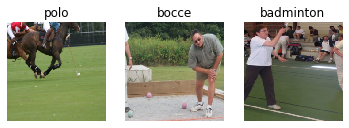

In [8]:
batch = next(iter(loader['train']))
samples = batch[0][:3]
y_true = batch[1]
for i, sample in enumerate(samples):
    plt.subplot(1, 3, i+1)
    plt.title(f'{class_names[y_true[i]]}')
    inp = sample.numpy().transpose((1, 2, 0))
    mean = np.array([0.47637546, 0.485785  , 0.4522678 ])
    std = np.array([0.24692202, 0.24377407, 0.2667196 ])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')

### Pick one of the pre-trained models, replace its final layer setting its output to the number of classes.

In [10]:
model = models.__dict__[model_name](pretrained=True) # Set false to train from scratch
# Alter the final layer
final_layer_input = model.fc.in_features
# nn.Linear a linear transformation to the incoming data: y = x A^T + b
model.fc = nn.Linear(final_layer_input, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=learning_rate, 
                      momentum=momentum, 
                      weight_decay=weight_decay,
                     )
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Using pre-trained weights

In [11]:
model.state_dict()

OrderedDict([('conv1.weight',
              tensor([[[[-1.0419e-02, -6.1356e-03, -1.8098e-03,  ...,  5.6615e-02,
                          1.7083e-02, -1.2694e-02],
                        [ 1.1083e-02,  9.5276e-03, -1.0993e-01,  ..., -2.7124e-01,
                         -1.2907e-01,  3.7424e-03],
                        [-6.9434e-03,  5.9089e-02,  2.9548e-01,  ...,  5.1972e-01,
                          2.5632e-01,  6.3573e-02],
                        ...,
                        [-2.7535e-02,  1.6045e-02,  7.2595e-02,  ..., -3.3285e-01,
                         -4.2058e-01, -2.5781e-01],
                        [ 3.0613e-02,  4.0960e-02,  6.2850e-02,  ...,  4.1384e-01,
                          3.9359e-01,  1.6606e-01],
                        [-1.3736e-02, -3.6746e-03, -2.4084e-02,  ..., -1.5070e-01,
                         -8.2230e-02, -5.7828e-03]],
              
                       [[-1.1397e-02, -2.6619e-02, -3.4641e-02,  ...,  3.2521e-02,
                          6.6221

### Train the model

In [102]:
def process_batch(inputs, targets, model, criterion, optimizer, is_training):
    """
    Process a minibatch for loss and accuracy.
    """
    
    # Convert tensors to Variables (for autograd)
    if is_training:
        X_batch = Variable(inputs, requires_grad=False)
    else:
        X_batch = Variable(inputs, requires_grad=False)
    y_batch = Variable(targets.long(), requires_grad=False)

    # Forward pass
    scores = model(X_batch) # logits

    # Loss
    loss = criterion(scores, y_batch)
    
    # Accuracy
    score, predicted = torch.max(scores, 1)
    accuracy = (y_batch.data == predicted.data).sum() / float(len(y_batch))
    
    if is_training:

        # In PyTorch, we need to set the gradients to zero before starting to
        # do backpropragation because PyTorch accumulates the gradients on subsequent
        # backward passes.
        optimizer.zero_grad()
        loss.backward()
        
        # Clip the gradient norms
        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        # Update params
        optimizer.step()

    return loss, accuracy

In [103]:
def train(model, criterion, optimizer, train_loader, test_loader, 
          num_epochs, batch_size, log_interval, learning_rate,
          dropout_p, decay_rate, max_grad_norm):
    """
    Training the model.
    """
    
    # Metrics
    train_loss, train_acc = [], []
    test_loss, test_acc = [], []

    # Training
    for num_train_epoch in range(num_epochs):
        # Timer
        start = time.time()

        # Decay learning rate
        learning_rate = learning_rate * (decay_rate ** (num_train_epoch // 1.0))
        for param_group in optimizer.param_groups:
            param_group['lr'] = learning_rate

        # Metrics
        train_batch_loss, train_batch_accuracy = 0.0, 0.0

        for train_batch_num, (inputs, target) in enumerate(train_loader):
            # Get metrics
            model.train()
            loss, accuracy = process_batch(
                inputs, target, model, criterion, optimizer, model.training)
            
            # Add to batch scalars
            train_batch_loss += loss.data.item() / float(len(inputs))
            train_batch_accuracy += accuracy
            
        # Add to global metrics
        train_loss.append(train_batch_loss / float(train_batch_num+1))
        train_acc.append(train_batch_accuracy / float(train_batch_num+1))

        # Testing
        model.eval()
        for num_test_epoch in range(1):
            # Metrics
            test_batch_loss, test_batch_accuracy = 0.0, 0.0

            for test_batch_num, (inputs, target) in enumerate(test_loader):
                # Get metrics
                model.eval()
                loss, accuracy = process_batch(
                    inputs, target, model, criterion, optimizer, model.training)
                # Add to batch scalars
                test_batch_loss += loss.data.item() / float(len(inputs))
                test_batch_accuracy += accuracy

            # Add to global metrics
            test_loss.append(test_batch_loss / float(test_batch_num+1))
            test_acc.append(test_batch_accuracy / float(test_batch_num+1))
                

            verbose_condition = ((num_train_epoch == 0) or (num_train_epoch % log_interval == 0) 
                                 or (num_train_epoch == num_epochs-1))

            # Verbose
            if verbose_condition:
                time_remain = (time.time() - start) * (num_epochs - (num_train_epoch + 1))
                minutes = time_remain // 60
                seconds = time_remain - minutes * 60
                print(f'TIME REMAINING: {minutes:.0f}m {seconds:.0f}s')
                print(f'[EPOCH]: {num_train_epoch},'
                      f'[TRAIN LOSS]: {train_batch_loss / float(train_batch_num+1):.6f},'
                      f'[TRAIN ACC]: {train_batch_accuracy / float(train_batch_num+1):.3f},'
                      f'[VAL LOSS]: {test_batch_loss / float(test_batch_num+1):.6f},'
                      f'[VAL ACC]: {test_batch_accuracy / float(test_batch_num+1):.3f}')
    return model

In [104]:
model = train(model, criterion, optimizer, loader['train'], loader['val'], 
              num_epochs, batch_size, log_interval, learning_rate,
              dropout_p, decay_rate, max_grad_norm)

TIME REMAINING: 2m 21s
[EPOCH]: 0,[TRAIN LOSS]: 0.003768,[TRAIN ACC]: 0.962,[VAL LOSS]: 0.010911,[VAL ACC]: 0.901
TIME REMAINING: 0m 0s
[EPOCH]: 1,[TRAIN LOSS]: 0.003156,[TRAIN ACC]: 0.965,[VAL LOSS]: 0.009032,[VAL ACC]: 0.930


### Inference

In [105]:
def infer(model, inputs):
    """
    Inference.
    """
    
    # Convert tensors to Variables (for autograd)
    X_batch = Variable(inputs, requires_grad=False)
    # Forward pass
    scores = model(X_batch)  # logits
    score, predicted = torch.max(scores, 1)
    return predicted

### Run prediction on a few images from test set

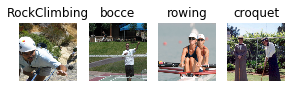

In [106]:
# Visualise some predictions
batch = next(iter(loader['test']))
samples = batch[0][:4]
y_preds = infer(model, samples)
for i, sample in enumerate(samples):
    plt.subplot(1, 5, i+1)
    plt.title(f'{class_names[y_preds[i]]}')
    inp = sample.numpy().transpose((1, 2, 0))
    mean = np.array([0.47637546, 0.485785  , 0.4522678 ])
    std = np.array([0.24692202, 0.24377407, 0.2667196 ])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')

## Inferencing with ONNX and ONNX Runtime


### Conversion to ONNX
First, we will export this model to the interoperable ONNX format. 

In [107]:
dummy_input = torch.randn(4, 3, 224, 224)
torch.onnx.export(model, dummy_input, "sports_classification-pretrained.onnx")

### Visualise using Netron

Visualise the ONNX model using Netron: https://lutzroeder.github.io/netron/

### To inference with the ONNX format, we'll be using [ONNX Runtime](https://aka.ms/onnxruntime).

#### Load ONNX model

In [108]:
from onnxruntime import InferenceSession

ort_session = InferenceSession('sports_classification-pretrained.onnx')

#### Run prediction on ONNX model

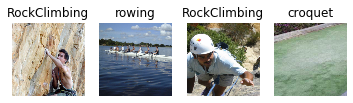

In [110]:
# Visualise onnx predictions
batch = next(iter(loader['test']))
samples = batch[0][:4]
outputs = np.argmax(ort_session.run(None, {'input.1': samples.numpy()})[0], axis=1)
for i, sample in enumerate(samples):
    plt.subplot(1, 4, i+1)
    plt.title(f'{class_names[outputs[i]]}')
    inp = sample.numpy().transpose((1, 2, 0))
    mean = np.array([0.47637546, 0.485785  , 0.4522678 ])
    std = np.array([0.24692202, 0.24377407, 0.2667196 ])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    plt.axis('off')